<a href="https://colab.research.google.com/github/ryanharvey1/teamA-grebes-NMA2020/blob/master/speed_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find running calcium response correlations

This script finds significant linear relationships between calcium response and running speed

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

# plt.rcParams.update({'font.size': 40})
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd  
import numpy as np 
from scipy import stats  
from itertools import compress

In [3]:
def figsize(scale):
	fig_width_pt = 483.69687                        # Get this from LaTeX using \the\textwidth
	inches_per_pt = 1.0/72.27                       # Convert pt to inch
	golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
	fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
	fig_height = fig_width*golden_mean        # height in inches
	fig_size = [fig_width,fig_height]
	return fig_size

## download data

TODO: make general for wider dataset

In [6]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())        

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## get spearman correlation

In [7]:
def compute_correlation(speed,fr):
  speed_score,_ = stats.spearmanr(speed,fr)
  return speed_score

## get slope and intercept using linear regression

In [8]:
def get_slope_intercept(speed,fr):

  x = speed[np.newaxis].T
  y = fr[np.newaxis].T

  model = LinearRegression()
  model.fit(x,y)

  m = model.coef_
  b = model.intercept_
  return m,b

## get speed maps 

speed maps are the mean neural response at each speed bin 

In [9]:
def get_speed_map(speed,fr):
  speed_vec = np.arange(min(speed),np.percentile(speed,95),2)

  fr_speed_maps = []
  # get mean firing rate in each speed bin
  for j in range(len(speed_vec)-1):
    start = speed_vec[j]
    stop = speed_vec[j+1]

    idx = [speed > start] and [speed < stop]
    fr_speed_maps.append(np.mean(fr[tuple(idx)]))

    # sem.append(np.std(fr(idx)) / np.sqrt(len(fr(idx))))
  return fr_speed_maps

## Get speed modulation

This is generated as to control for significant tuning with a very small range

In [10]:
def speed_modulation(speed_map):
  speed_mod = (max(speed_map) - min(speed_map)) / np.mean(speed_map)
  return np.array(speed_mod)

## shuffle speed modulation and correlation

Each cell’s response vector was shuffled by a random interval from ~20 s before or after its true position to obtain a null distribution for each cell

In [11]:
def pvalue(shuff_dist,score):
  # DOI: 10.2202/1544-6115.1585
  return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

def shuffle(speed_mod,speed_cor,speed,fr,shuffn=250,shuff_range=24):
  
  # make random vector of shuffle amounts
  r = np.random.randint(-shuff_range,shuff_range,shuffn)

  speed_mod_shuff = []
  speed_score_shuff = []

  for i in range(len(r)):
    # shuffle speed modulation
    speed_map = get_speed_map(speed,np.roll(fr,r[i]))
    speed_mod_shuff.append(speed_modulation(speed_map))

    # shuffle speed correlation
    speed_score_shuff.append(compute_correlation(speed,np.roll(fr,r[i])))

  # return p values
  return pvalue(speed_mod_shuff,speed_mod), pvalue(speed_score_shuff,speed_cor)

## run though every cell

In [12]:
def run_all_cells(dat):
  cells,time = dat['sresp'].shape
  run = np.squeeze(dat['run'])
  X = dat['sresp']

  speed_cor = []
  speed_cor_pvalue = []
  m = []
  b = []
  speed_map = []
  speed_mod = []
  speed_mod_pvalue = []

  for i in range(cells):
    
    # get speed response correlation
    speed_cor.append(compute_correlation(run,X[i,:]))
    
    # linear regression
    m_,b_ = get_slope_intercept(run,X[i,:])
    m.append(m_)
    b.append(b_)

    # speed map
    speed_map.append((get_speed_map(run,X[i,:])))

    # speed modulation
    speed_mod.append(speed_modulation(speed_map[-1]))  

    # shuffle speed correlation & speed modulation
    p1, p2 = shuffle(speed_mod[-1],speed_cor[-1],run,X[i,:])
    speed_mod_pvalue.append(p1)
    speed_cor_pvalue.append(p2)

    # update counter
    sys.stdout.write('\rcurrent cell: %d' %(cells - i))
    sys.stdout.flush()

  d={'speed_cor': speed_cor, 'speed_cor_pvalue': speed_cor_pvalue,
          'slope': m, 'intercept': b, 'speed_mod': speed_mod,
    'speed_mod_pvalue': speed_mod_pvalue}

  return pd.DataFrame(d), speed_map

df,speed_map = run_all_cells(dat)
np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy',speed_map)
df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")

df

current cell: 1

,speed_cor,speed_cor_pvalue,slope,intercept,speed_mod,speed_mod_pvalue
0,0.037081,0.031873,[[0.04655153712639664]],[6.701278006979309],0.029077431,0.059761
1,-0.015747,0.119522,[[-0.008001666373229879]],[5.433671749085655],0.010097089,0.274900
2,-0.008763,0.454183,[[-0.0073181789721904495]],[4.6965754671733455],0.010708806,0.159363
3,0.196378,0.003984,[[0.06816048084295674]],[8.474296393925272],0.16257545,0.035857
4,0.008459,0.278884,[[0.08151148078289507]],[13.27337580967431],0.009054725,0.390438
...,...,...,...,...,...,...
11978,-0.028630,0.007968,[[-0.31601890375345476]],[86.03674125511317],0.0073964316,0.561753
11979,0.009240,0.557769,[[-0.020151207141361857]],[35.48008323940126],0.024111908,0.003984
11980,-0.031522,0.031873,[[-0.010835917051686884]],[32.71565770394717],0.017061893,0.207171
11981,-0.000512,0.968127,[[-0.16513455051549225]],[53.14822019287467],0.0088076275,0.266932


## If data was already ran, load it here

In [4]:
if "speed_map" in locals():
  print('saving')
  np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy',speed_map)
else:
  print('loading...')
  speed_map = np.load('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy')

if "df" in locals():
  df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")
else:
  df = pd.read_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_df.pkl")
df

loading...


,speed_cor,speed_cor_pvalue,slope,intercept,speed_mod,speed_mod_pvalue
0,0.037081,0.071713,[[0.04655153712639664]],[6.701278006979309],0.029077431,0.087649
1,-0.015747,0.079681,[[-0.008001666373229879]],[5.433671749085655],0.010097089,0.270916
2,-0.008763,0.501992,[[-0.0073181789721904495]],[4.6965754671733455],0.010708806,0.135458
3,0.196378,0.003984,[[0.06816048084295674]],[8.474296393925272],0.16257545,0.019920
4,0.008459,0.262948,[[0.08151148078289507]],[13.27337580967431],0.009054725,0.394422
5,-0.029632,0.003984,[[-0.022779712878406386]],[4.758289627204094],0.018073713,0.003984
6,-0.080405,0.059761,[[-0.3680535458087703]],[16.69701800152158],0.059123397,0.003984
7,0.014855,0.486056,[[0.025644815658084675]],[15.339829078480149],0.003800925,0.960159
8,-0.015107,0.019920,[[-0.013468543184855844]],[4.889092159405437],0.013628495,0.067729
9,-0.031581,0.075697,[[-0.004844283802654008]],[4.691449942045376],0.010744819,0.127490


## speed modulated cells

significant correlation & speed modulation score

In [32]:
idx = (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)
print(sum(idx), ' of ', len(df),' cells')
print(np.mean(idx),' of cells are speed modulated')

2892  of  11983  cells
0.24134190102645414  of cells are speed modulated


## Figures

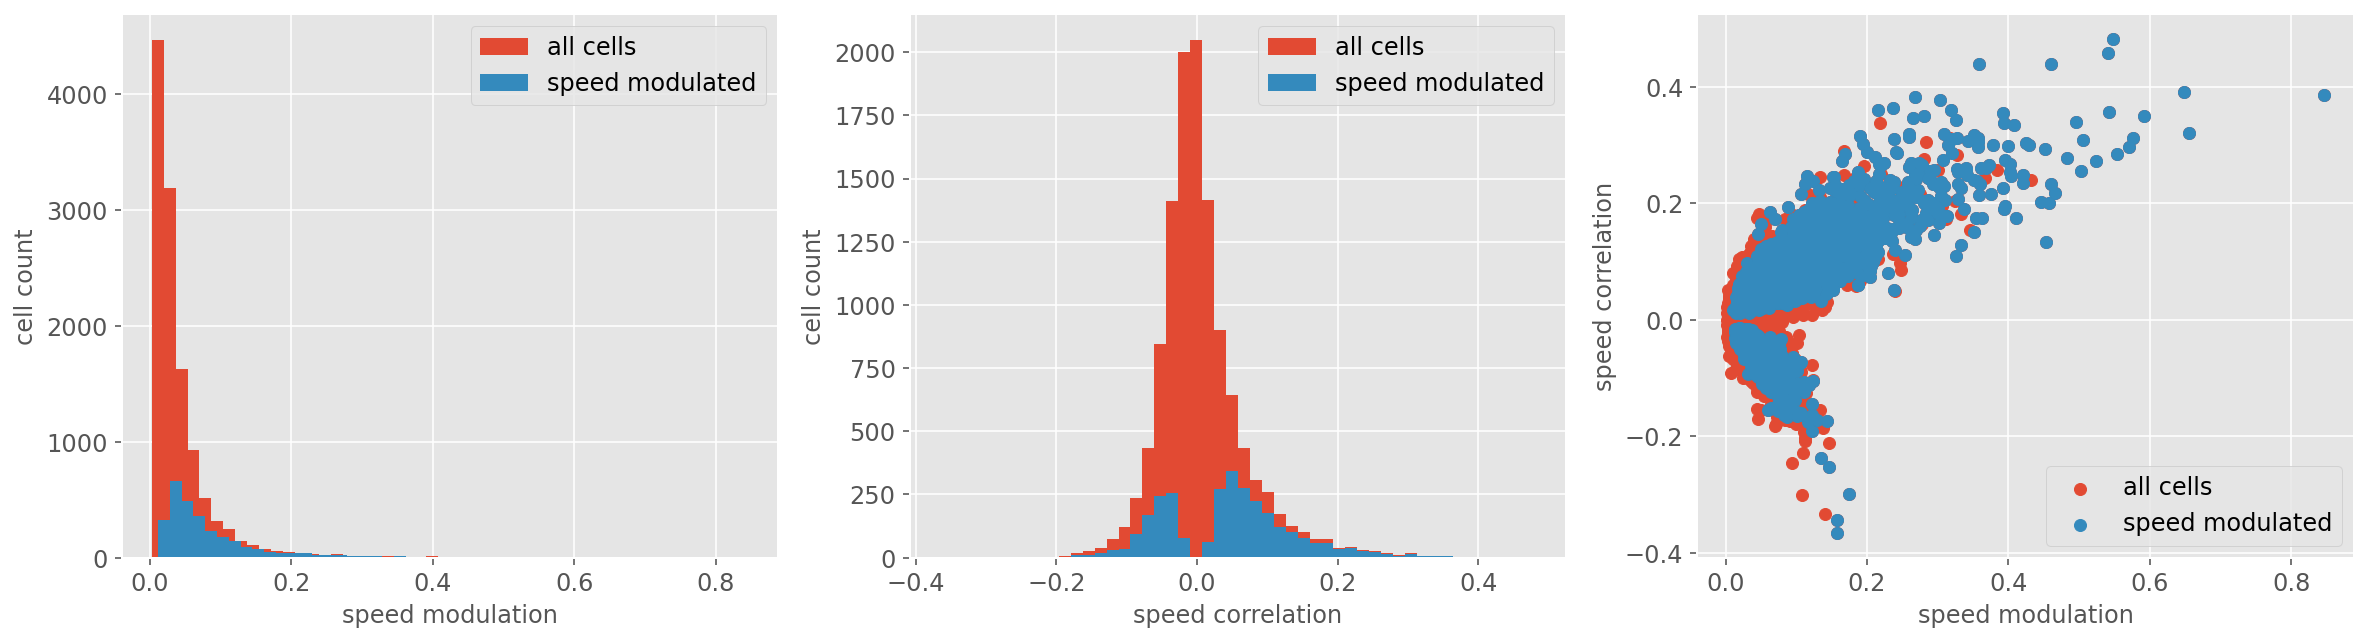

In [49]:
idx = (df.speed_cor_pvalue < 0.05) & (df.speed_mod_pvalue < 0.05)

fig, axs = plt.subplots(1,3, figsize=(20, 5), edgecolor='k')

axs[0].hist(df.speed_mod,50,
         label='all cells')
axs[0].hist(df.speed_mod[idx],
         50,label='speed modulated')
axs[0].set_xlabel('speed modulation')
axs[0].set_ylabel('cell count')
axs[0].legend()

axs[1].hist(df.speed_cor,50,
         label='all cells')
axs[1].hist(df.speed_cor[idx],
         50,label='speed modulated')
axs[1].set_xlabel('speed correlation')
axs[1].set_ylabel('cell count')
axs[1].legend()

axs[2].scatter(df.speed_mod,df.speed_cor,label='all cells')
axs[2].scatter(df.speed_mod[idx],df.speed_cor[idx],label='speed modulated')
axs[2].set_xlabel('speed modulation')
axs[2].set_ylabel('speed correlation')
axs[2].legend()

## randomly display some sig speed maps

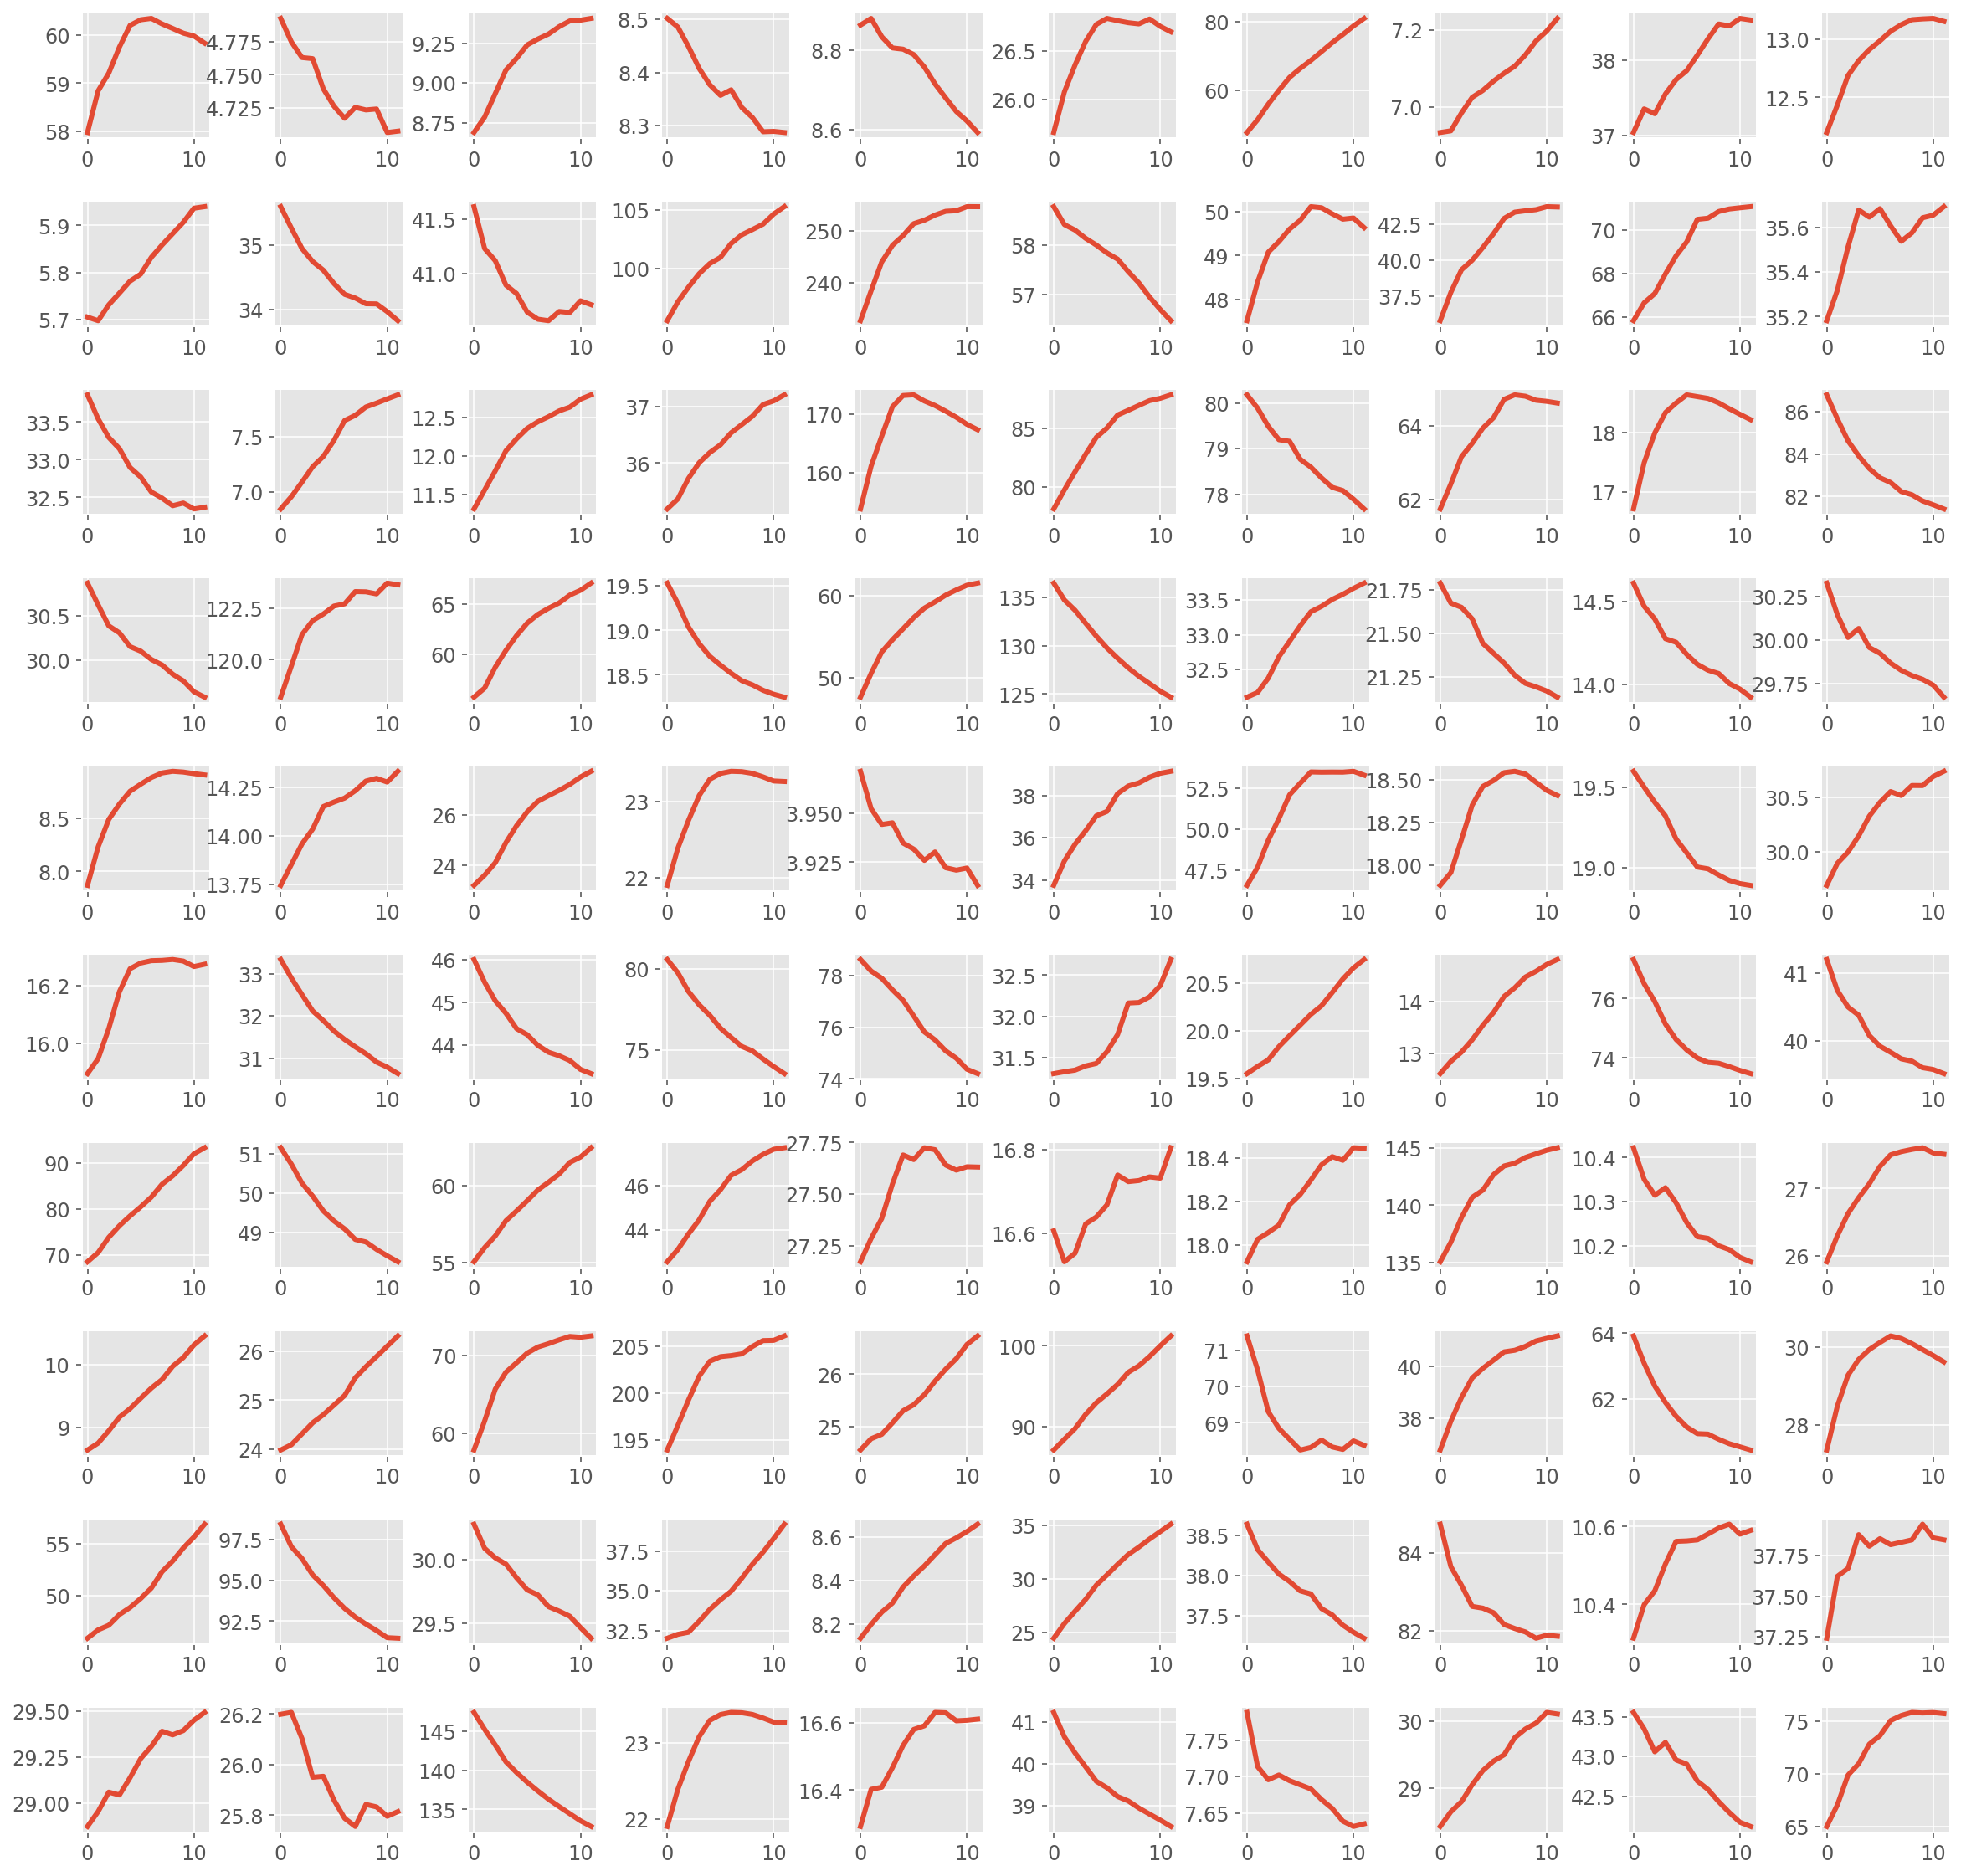

In [69]:
sig_speed_map = list(compress(speed_map,idx))

r = np.random.randint(0,len(sig_speed_map),100)

fig, axs = plt.subplots(10,10, figsize=(20, 20), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

for i in range(100):
  axs[i].plot(sig_speed_map[r[i]],linewidth=3)
  # axs[i].axis('off')
  # plt.xlabel('speed (a.u.)')
  # plt.ylabel('Calcium response')
  # plt.grid()

from google.colab import files
fig.savefig("tuning.pdf")
files.download("tuning.pdf")   